In [1]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/home/ubuntu/Github/DataEngineerChallenge/spark-2.4.4-bin-hadoop2.7"

import numpy as np
import pandas as pd
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, max, sum, mean
from pyspark.sql.functions import col, when, count, countDistinct
from pyspark.sql.functions import split, concat_ws
from pyspark.sql.types import StructField, StructType
from pyspark.sql.types import StringType, FloatType
from pyspark.sql.functions import lit
from pyspark.sql.functions import from_unixtime, unix_timestamp, to_date




if "spark" not in dir():
    spark = SparkSession.builder \
    .appName("web_log_analysis") \
    .getOrCreate()
    
logFile = "data/2015_07_22_mktplace_shop_web_log_sample.log.gz"
numPartitions = 15
session_time = 15*60



def preprocess1(spark):
    log_schema = StructType([
        StructField("timestamp", StringType(), False),
        StructField("elb", StringType(), False),
        StructField("client:port", StringType(), False),
        StructField("backend:port", StringType(), False),
        StructField("request_processing_time", StringType(), False),
        StructField("backend_processing_time", StringType(), False),
        StructField("response_processing_time", StringType(), False),
        StructField("elb_status_code", StringType(), False),
        StructField("backend_status_code", StringType(), False),
        StructField("received_bytes", StringType(), False),
        StructField("sent_bytes", StringType(), False),
        StructField("request", StringType(), False),
        StructField("user_agent", StringType(), False),
        StructField("ssl_cipher", StringType(), False),
        StructField("ssl_protocol", StringType(), False)])
    
    df = spark.read.csv(logFile, schema=log_schema, sep=" ").repartition(numPartitions).cache()
    split_client = split(df["client:port"], ":")
    split_backend = split(df["backend:port"], ":")
    split_request = split(df["request"], " ")
    
    #df2=df.withColumn("time", col("timestamp").cast("timestamp")).drop("client:port","backend:port","request","timestamp", "elb", "request_processing_time", "backend_processing_time", "response_processing_time", "elb_status_code", "backend_status_code", "received_bytes", "sent_bytes", "user_agent", "ssl_cipher", "ssl_protocol").cache().
    df=df.withColumn("time", col("timestamp").cast("timestamp")).withColumn("load",lit(1)).drop("client:port",
                                                                                                "backend:port","request","timestamp", "elb", "request_processing_time", 
                                                                                                "backend_processing_time", "response_processing_time", "elb_status_code", 
                                                                                                "backend_status_code", "received_bytes", "sent_bytes", "user_agent", 
                                                                                                "ssl_cipher", "ssl_protocol");
    
    df=df.withColumn("time", from_unixtime(unix_timestamp(col("time"), "yyyy-MM-dd HH:mm:ss.SSSSSS"),"yyyy-MM-dd HH:mm:ss"));
    df = df.groupby("time").agg(sum("load").alias("load")).cache()
    df=df.orderBy(col("time"))
    return df;


def solve1(spark):
    dataset1 = preprocess1(spark).cache()
    dataset1.show();
    return dataset1.select("*").toPandas();

df=solve1(spark)

+-------------------+----+
|               time|load|
+-------------------+----+
|2015-07-22 02:40:06|  27|
|2015-07-22 02:40:07|  62|
|2015-07-22 02:40:08|  56|
|2015-07-22 02:40:09| 112|
|2015-07-22 02:40:10|  58|
|2015-07-22 02:40:11|  58|
|2015-07-22 02:40:12|  67|
|2015-07-22 02:40:13|  85|
|2015-07-22 02:40:14| 160|
|2015-07-22 02:40:15|  57|
|2015-07-22 02:40:16|  99|
|2015-07-22 02:40:17|  96|
|2015-07-22 02:40:18|  95|
|2015-07-22 02:40:19|  65|
|2015-07-22 02:40:20| 130|
|2015-07-22 02:40:21|  65|
|2015-07-22 02:40:22|  59|
|2015-07-22 02:40:23|  62|
|2015-07-22 02:40:24|  89|
|2015-07-22 02:40:25| 130|
+-------------------+----+
only showing top 20 rows



In [2]:
print(df.head());
print(df.shape)

                  time  load
0  2015-07-22 02:40:06    27
1  2015-07-22 02:40:07    62
2  2015-07-22 02:40:08    56
3  2015-07-22 02:40:09   112
4  2015-07-22 02:40:10    58
(4269, 2)


In [3]:
data_dateIndexed=df.set_index("time");
data_dateIndexed_train = data_dateIndexed[:-600]
data_dateIndexed_test = data_dateIndexed[-600:]

data_dateIndexed_train=data_dateIndexed_train[["load"]];
data_dateIndexed_test=data_dateIndexed_test[["load"]];

print(data_dateIndexed_train.shape)
print(data_dateIndexed_test.shape)
print(data_dateIndexed_train.shape[0]+data_dateIndexed_test.shape[0])

(3669, 1)
(600, 1)
4269


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


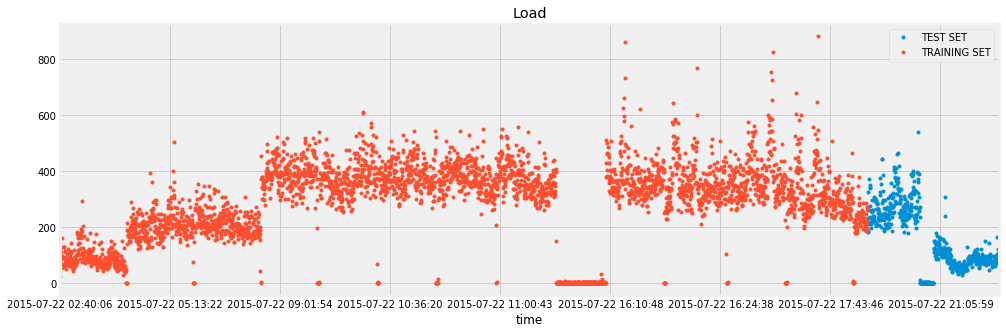

In [5]:
_ = data_dateIndexed_test \
    .rename(columns={'load': 'TEST SET'}) \
    .join(data_dateIndexed_train.rename(columns={'load': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Load', style='.')

In [6]:
data_dateIndexed_train.reset_index().rename(columns={'time':'x', 'load':'y'}).head()

,x,y
0,2015-07-22 02:40:06,27
1,2015-07-22 02:40:07,62
2,2015-07-22 02:40:08,56
3,2015-07-22 02:40:09,112
4,2015-07-22 02:40:10,58


In [7]:
model = Prophet()
model.fit(data_dateIndexed_train.reset_index().rename(columns={'time':'ds', 'load':'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/sparkk/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [8]:
data_dateIndexed_test_fcst = model.predict(df=data_dateIndexed_test.reset_index().rename(columns={'time':'ds'}))

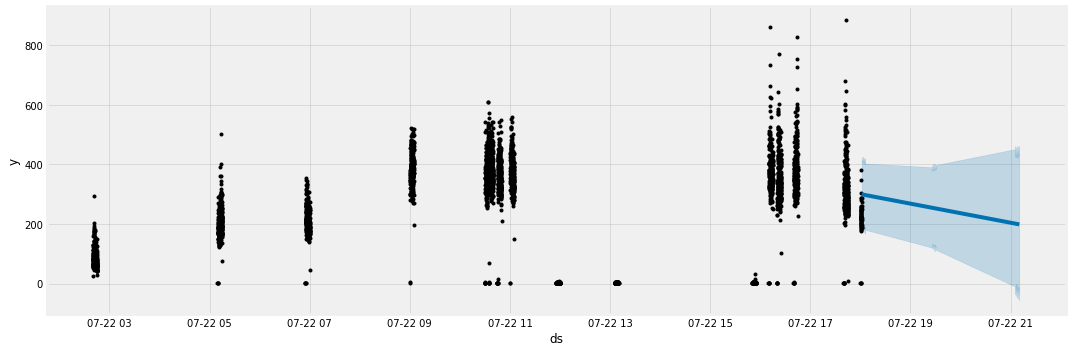

In [9]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(data_dateIndexed_test_fcst, ax=ax)

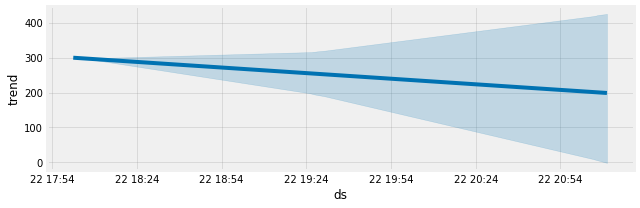

In [10]:
fig = model.plot_components(data_dateIndexed_test_fcst)


In [11]:
mean_squared_error(y_true=data_dateIndexed_test['load'],
                   y_pred=data_dateIndexed_test_fcst['yhat'])

15036.753579727296

In [12]:
mean_absolute_error(y_true=data_dateIndexed_test['load'],
                   y_pred=data_dateIndexed_test_fcst['yhat'])

104.21359632683988